# Spatial analysis of Chicago burglary crime patterns 

## 1.0 Introduction and analysis context

### 1.1 Context and literature review

The continuous digitisation of police recorded crime statistics enables researchers and authorities to probe urban crime in depth. There are several related studies from different perspectives and using various computational techniques. From an academic and governing angle, spatial analysis of criminal activities plays an essential role in criminological research and policymaking (Andresen, 2005). A spatial analysis of the burglary crime incidents could help policymakers allocate public and human resources to where they can be most effective. Better management of burglary risk can potentially have a positive economic impact. In the united states alone, burglary offences caused around USD 3.0 billion in property losses in 2019 (FBI, 2019). Spatial patterns of the burglary that this project found can be associated with other local socio-economic factors to determine which kind of neighbourhoods are prone to burglaries (Craglia, Haining and Wiles, 2000).  



### 1.2 Project goals

This project aims to provide a statistical spatial analysis of burglary crime incidents in Chicago and related visualisations. 
Appropriate clustering methods will identify clusters of crime incidents and administrative regions with a high burglary rate.
The underlaying socio-economic factors that correlate with high crime risk will be investigated by regression methods.

Goals bullet points and their potential real-world impacts:<br>

| Tasks | Task Categories | Real-world impacts |
| :---        |    :----  |          :--- |
| Identification of burglary crime clusters | Classification of point data | Crime control and preventation, a more efficient use of the police force |
| Identification of communities with exceptional burglary crime rat | Classification of polygons (administrative area) | Local policy change |
| Identification of socio-economic factors that correlate with burglary rate | Regression | Prediction of high-burglary-rate areas |

### 1.3 Data source 

The complete dataset of Chicago crime incidents from 2001 to the present is available through Chicago Data Portal. However, due to the scope of this analysis and the dataset's massive nature (over 7.5 million rows in March 2022), a filter is essential for obtaining a suitable subset, which contains burglary records only, and a swift data preprocessing and validation section. One way to implement such a filter is using a python package called sodapy, which is not available inside the SDS computing environment. An example is here: [github link]. The example python code needs an app token (registration with Chicago Data Portal required) and one line of NoSQL query to run.

Chicago crimes -2001 to Present: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

The web page above includes metadata and column descriptions. Two columns, 'Latitude' and 'Longitude', make the geocoding of the point crime events possible.

The Data Portal offers shapefiles of Chicago wards. This project utilised shapefiles to provide an intuitive map of urban burglary density and risk.

Chicago Boundaries - Wards (2015 - ): https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Wards-2015-/sp34-6z76

### 1.4 Package requirement

In [1]:
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import BallTree

123

## 2. Data preparation

### 2.1 Data Input

In [65]:
BURGLARY_2020 = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/BURGLARY_2020.csv"
)
chicago_community_pop = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/chicago_community_population.CSV"
)
chicago_community = gpd.read_file(
    "/vsicurl/https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/geo_export_d1f0aa30-5958-4286-841c-d61250028149.shp"
)

In the section below, there are five rows of the dataset. 

In [3]:
chicago_community_pop
chicago_community_pop.rename(columns={"No.": "community number"}, inplace=True)
chicago_community_pop

,community number,Population
0,1,55628
1,2,77122
2,3,57182
3,4,40494
4,5,35114
...,...,...
72,73,25065
73,74,18628
74,75,21186
75,76,13418


In [66]:
community_type = ["community"] * len(chicago_community.index)
chicago_community["community"] = community_type
chicago_community = chicago_community.rename(columns={"area_numbe": "community number"})
chicago_community

,area,area_num_1,community number,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,community,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,community,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,community,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,community,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,community,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,community,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,75,0.0,0.0,community,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,76,0.0,0.0,community,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,0.0,77,77,0.0,0.0,community,0.0,4.844999e+07,31004.830946,"POLYGON ((-87.65456 41.99817, -87.65456 41.998..."


### 2.2 Data Preprocessing and Validation

Previous sections loaded datasets that this project will analyse. However, several data preprocessing steps should proceed before further analysis. The first step is data cleaning. In the 2020 dataset, there are over eight thousand rows of burglary records. To ensure a successful implementation of spatial analysis techniques (e.g. DBSCAN), filtering out rows that contain NULL, N/A, or zero values in the geographic location columns (e.g. latitude and longitude columns) is necessary. 

In [5]:
# Do not rerun the section after first attempt; otherwise the row number difference before and after the cleaning will not show
# Completeness check
before_clearning_size = BURGLARY_2020.shape[0]
BURGLARY_2020 = BURGLARY_2020[BURGLARY_2020["latitude"].notna()]
BURGLARY_2020 = BURGLARY_2020[BURGLARY_2020["longitude"].notna()]
after_clearning_size = BURGLARY_2020.shape[0]
print(
    "Before the first step of data cleaning, the 2020 dataset has "
    + str(before_clearning_size)
    + " rows"
    + " After cleaning, there are "
    + str(after_clearning_size)
    + " rows remaining"
)

Before the first step of data cleaning, the 2020 dataset has 8752 rows After cleaning, there are 8704 rows remaining


It is also possible that there are duplicate incidents. The section below will drop potential duplicate rows based on three columns: case_number, id and location.

In [6]:
# Duplicate identification and elimination
before_clearning_size2 = BURGLARY_2020.shape[0]
BURGLARY_2020.drop_duplicates(subset=["id", "case_number", "location"])
after_clearning_size2 = BURGLARY_2020.shape[0]
print(
    "Before the second step of data cleaning, the 2020 dataset has "
    + str(before_clearning_size2)
    + " rows"
    + " After cleaning, there are "
    + str(after_clearning_size2)
    + " rows remaining"
)

Before the second step of data cleaning, the 2020 dataset has 8704 rows After cleaning, there are 8704 rows remaining


Fortunately, the Data Fulfillment and Analysis Section of the Chicago Police Department did not record any duplicate cases in 2020. The next step is data type checking. We require that location information is in numerical forms, such as float.

In [7]:
print("Column Latitude data type: " + str(BURGLARY_2020["latitude"].dtypes))
print("Column Longitude data type: " + str(BURGLARY_2020["longitude"].dtypes))

Column Latitude data type: float64
Column Longitude data type: float64


The data type of the two essential columns is, as expected, the float number. The final step of preprocessing should be outlier detection. However, due to the nature (official police records) of this 2020 dataset, it is unlikely that any data point is random. All rows have their wards and community numbers, which means removing isolated cases will reduce the burglary rate in administrative areas and cause bias. While applying DBSCAN, the algorithm will automatically disregard incidents that do not belong to any clusters. This project will not use statistical methods to detect and remove outlier events at the preprocessing stage.

### 2.3 Data Munging

There is one row of the burglary case record in the section below. Twenty-three columns provide a rich range of information, but not all of them are essential ingredients for a spatial study. Among them, four columns: ward, community area, latitude and longitude, will take part in the spatial analysis. Neither regression nor classification will use all remaining descriptive columns and temporal elements.

In [8]:
BURGLARY_2020.head(1)

,Unnamed: 0,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,0,12013851,JD191098,2020-03-13T15:00:00.000,046XX W JACKSON BLVD,610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,...,28,25,5,1145423.0,1898285.0,2020,2020-03-25T15:45:43.000,41.876892,-87.741518,"{'latitude': '41.876891751', 'longitude': '-87..."


In [27]:
# Removal of superfluous columns
BURGLARY_2020_spatial = BURGLARY_2020[
    ["id", "primary_type", "ward", "community_area", "latitude", "longitude"]
]

After reducing the complete dataset to a dataset with only municipal locations and coordinates in WSG84, pivot tables can provide an overview of the burglary case distribution across different levels of Chicago municipal districts.

In [28]:
# pivot tables initialisation
ward_count = BURGLARY_2020_spatial["ward"].value_counts()
community_count = BURGLARY_2020_spatial["community_area"].value_counts()

In [29]:
# override CSS to make multiple dataframes be able to display together
# https://softhints.com/display-two-pandas-dataframes-side-by-side-jupyter-notebook/
css = """
.output {
    flex-direction: row;
}
"""

HTML("<style>{}</style>".format(css))

In [30]:
# pivot tables sorting and display
community_count = community_count.sort_index()
community_count_frame = pd.DataFrame(
    {
        "community number": community_count.index,
        "burglary count 2020": community_count.values,
    }
)

ward_count = ward_count.sort_index()
ward_count_frame = pd.DataFrame(
    {"ward": ward_count.index, "burglary count 2020": ward_count.values}
)

display(community_count_frame.head())
display(ward_count_frame.head())

,community number,burglary count 2020
0,1,117
1,2,167
2,3,112
3,4,100
4,5,84


,ward,burglary count 2020
0,1,191
1,2,189
2,3,166
3,4,176
4,5,277


In the first five districts (ward or community), we can see the variation in incident numbers between different areas.

### 2.4 Data Merging

Given that community population data and total burglary incident numbers within communities are available, it is straightforward to calculate the burglary rate (incidents per unit of population). The reason for choosing community-level analysis rather than ward is the ward is a political district, and ward boundaries change to reflect population shifts. Community borders, in contrast, are stable over time

In [13]:
crime_rate_2020_frame = pd.merge(
    community_count_frame, chicago_community_pop, on="community number"
)
crime_rate_2020_frame
crime_rate_2020_frame["incident rate per 1000 people"] = crime_rate_2020_frame[
    "burglary count 2020"
] / (
    crime_rate_2020_frame["Population"] / 1000
)  # new column, incident rate per 1000 people, based on two existing columns: burglary count 2020 and population

crime_rate_2020_frame

,community number,burglary count 2020,Population,incident rate per 1000 people
0,1,117,55628,2.103257
1,2,167,77122,2.165400
2,3,112,57182,1.958658
3,4,100,40494,2.469502
4,5,84,35114,2.392208
...,...,...,...,...
72,73,114,25065,4.548175
73,74,13,18628,0.697874
74,75,87,21186,4.106485
75,76,6,13418,0.447161


Append burglary statistical data to the community dataframe.

In [81]:
chicago_community["community number"] = chicago_community["community number"].astype(
    int
)
chicago_community_sorted = chicago_community.sort_values(by=["community number"])
chicago_community_with_crime_data = pd.merge(
    chicago_community_sorted, crime_rate_2020_frame, on="community number"
)
chicago_community_with_crime_data

,area,community number,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,burglary count 2020,Population,incident rate per 1000 people
0,0.0,1,0.0,0.0,community,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",117,55628,2.103257
1,0.0,2,0.0,0.0,community,0.0,9.842909e+07,43020.689458,"POLYGON ((-87.68465 42.01948, -87.68464 42.019...",167,77122,2.165400
2,0.0,3,0.0,0.0,community,0.0,6.509564e+07,46972.794555,"POLYGON ((-87.64102 41.95480, -87.64400 41.954...",112,57182,1.958658
3,0.0,4,0.0,0.0,community,0.0,7.135233e+07,36624.603085,"POLYGON ((-87.67441 41.97610, -87.67440 41.976...",100,40494,2.469502
4,0.0,5,0.0,0.0,community,0.0,5.705417e+07,31391.669754,"POLYGON ((-87.67336 41.93234, -87.67342 41.932...",84,35114,2.392208
...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,73,0.0,0.0,community,0.0,7.963575e+07,42222.598163,"POLYGON ((-87.63373 41.72885, -87.63369 41.726...",114,25065,4.548175
73,0.0,74,0.0,0.0,community,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706...",13,18628,0.697874
74,0.0,75,0.0,0.0,community,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685...",87,21186,4.106485
75,0.0,76,0.0,0.0,community,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",6,13418,0.447161


## 3. Exploratory Data Analysis

### 3.1 Crime Map

With the help from the package geopandas, this section plots the visualisation of locations of crime events over the Chicago map. This raw represetation provides an intuitive impression, the burglary pattern does not have a even distribution across the space. Four south-east districts and a few north-west areas have fewer cases compared with remaining communities.

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
No handles with labels found to put in legend.


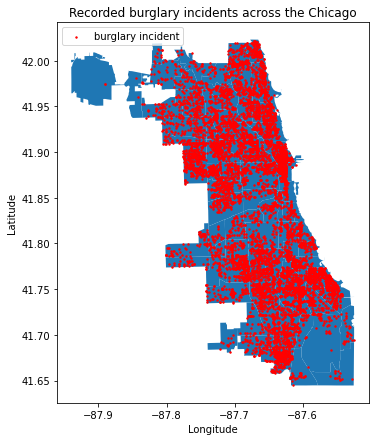

In [63]:
crs = {
    "init": "epsg:4326"
}  # coordinate reference system for the latitude and longitude


geometry = [
    Point(xy)
    for xy in zip(BURGLARY_2020_spatial["longitude"], BURGLARY_2020_spatial["latitude"])
]


geodata = gpd.GeoDataFrame(
    BURGLARY_2020_spatial, crs=crs, geometry=geometry
)  # burglary incident point data


fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Recorded burglary incidents across the Chicago")

chicago_community.plot(ax=ax, legend=True, column="community", categorical=True)
ax.legend()
ax.scatter(
    BURGLARY_2020_spatial["longitude"],
    BURGLARY_2020_spatial["latitude"],
    label="burglary incident",
    s=2,
    c="red",
)
ax.legend()

# some ideas from this article: https://www.linkedin.com/pulse/geopandas-plotting-data-points-map-using-python-r%C3%A9gis-nisengwe/

### 3.2 Community-level Crime Rate 

Text(0.5, 1.0, 'Incident rate per 1000 people (community level)')

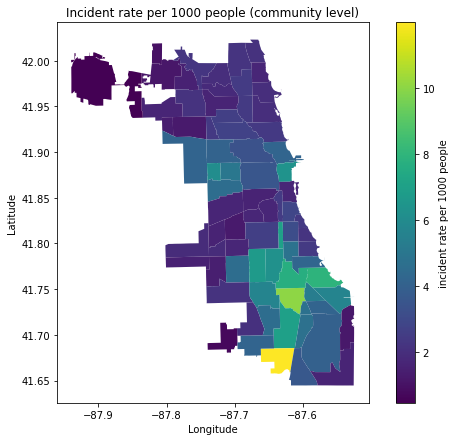

In [92]:
fig, ax = plt.subplots(figsize=(10, 7))
chicago_community_with_crime_data.plot(
    column="incident rate per 1000 people",
    ax=ax,
    legend=True,
    legend_kwds={"label": "incident rate per 1000 people"},
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Incident rate per 1000 people (community level)")

Text(0.5, 1.0, 'Total 2020 burglary count in each Chicago community')

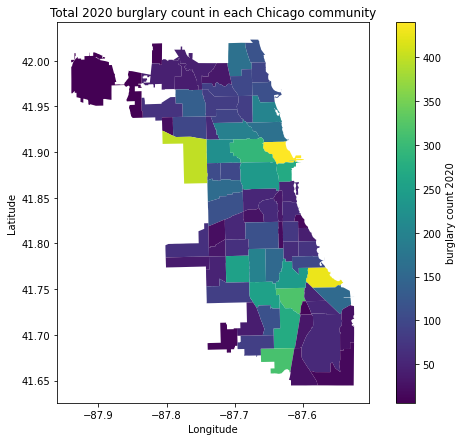

In [93]:
fig, ax = plt.subplots(figsize=(10, 7))
chicago_community_with_crime_data.plot(
    column="burglary count 2020",
    ax=ax,
    legend=True,
    legend_kwds={"label": "burglary count 2020"},
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Total 2020 burglary count in each Chicago community")

## 3. Methodology

### 3.1 DBSCAN (clustering)

A range of clustering methods, including the DBSCAN algorithm, K - Nearest Neighbor and Artificial Neural Network, were applicable to crime pattern mapping (Mungekar et al., 2021). This project will not evaluate different methods' performance. The choice of the approach is based on a study analysing six Indian cities. During the research, DBSCAN outperforms K-Means clustering and Agglomerative hierarchical clustering in terms of recall and precision (Sivaranjani, Sivakumari and Aasha, 2016).

DBSCAN (density-based spatial clustering of applications with noise) groups crowded points into groups and determines whether other points belong to any clusters. DBSCAN is an unsupervised learning method that requires two hyperparameters (epsilon, which determines the Euclidean searching radius of the data point; minPoints, which is the minimum number of other data points inside the search radius for the central data point to become a core point) to initialise. Within the search radius, if a point finds n (greater than zero but smaller than minPoints) other points, the point becomes a border point. The DBCAN algorithm first identifies and connects core points to form clusters and then connects border points to suitable clusters. A point that finds no other point within the search radius becomes a noise point. (Ester et al., 1996)

## 4. Data Analysis

### 4.1 DBSCAN 

#### 4.1.1 DBSCAN Hyperparameter Tuning (epsilon)

According to a case study (Rahmah and Sitanggang, 2016), an ascending plot of each point's distance to the nearest point can determine an optimal epsilon. The y-axis coordinate of the location, which has a significant slope change, is the suitable epsilon value. The Chicago crime data offers incident locations in latitude and longitude, bringing an extra layer of complexity during the distance calculation. Instead of a simple 2-D Euclidean distance equation, latitude and longitude pairs (spherical coordinates) need to use the haversine formula to find distance values between them. This section implements the haversine formula through the Balltree algorithm to solve the nearest neighbour problem.

In [94]:
# parts of code adopted from https://stackoverflow.com/questions/61952561/how-do-i-find-the-neighbors-of-points-containing-coordinates-in-python
DBSCANdf = BURGLARY_2020_spatial

# Setup Balltree using df as reference dataset
# Use Haversine calculate distance between points on the earth from lat/long
# haversine - https://pypi.org/project/haversine/
tree = BallTree(
    np.deg2rad(DBSCANdf[["latitude", "longitude"]].values), metric="haversine"
)


DBSCANdf_query = BURGLARY_2020_spatial

qlats = DBSCANdf_query["latitude"]
qlons = DBSCANdf_query["longitude"]

# use k = 2 for 1 closest neighbor (excluding the point itself)
distances, inx = tree.query(np.deg2rad(np.c_[qlats, qlons]), k=2)

distance_list = []
r_km = 6371  # multiplier to convert to km (from unit distance)
for name, d, ind in zip(DBSCANdf_query["id"], distances, inx):
    for i, index in enumerate(ind):
        distance_list.append(d[i] * r_km)

In [95]:
distance_list = [
    i for i in distance_list if i != 0
]  # remove zeros (distance to the point itself)
distance_list.sort()

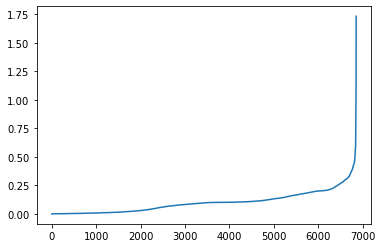

In [96]:
plt.plot(distance_list)

The plot has an 'elbow' when the y value is around 0.25 km. 

The choice of minPoints depends on the dimension of the dataset. There are two columns (latitude and longitude) matter in this spatial analysis, making the dimension of the dataset equals two. For a 2-dimensional dataset, the minpoints is 4. (Ester et al., 1996)

In [99]:
kms_per_radian = 6371.0088
epsilon = 0.3 / kms_per_radian

DBSCAN_result = BURGLARY_2020_spatial
coords = DBSCANdf_query[["latitude", "longitude"]].to_numpy()

db = DBSCAN(eps=epsilon, min_samples=12, algorithm="ball_tree", metric="haversine").fit(
    np.radians(coords)
)
DBSCAN_result["DBSCAN_opt_labels"] = db.labels_
DBSCAN_result["DBSCAN_opt_labels"].value_counts()
DBSCAN_result

,id,primary_type,ward,community_area,latitude,longitude,geometry,DBSCAN_opt_labels
0,12013851,BURGLARY,28,25,41.876892,-87.741518,POINT (-87.74152 41.87689),-1
1,12243263,BURGLARY,50,2,42.009054,-87.690172,POINT (-87.69017 42.00905),-1
2,12012798,BURGLARY,24,30,41.852736,-87.701119,POINT (-87.70112 41.85274),-1
3,12242514,BURGLARY,37,25,41.903967,-87.764385,POINT (-87.76438 41.90397),-1
4,12242335,BURGLARY,29,17,41.937990,-87.809915,POINT (-87.80992 41.93799),-1
...,...,...,...,...,...,...,...,...
8739,12203326,BURGLARY,33,14,41.970230,-87.712660,POINT (-87.71266 41.97023),69
8740,12220724,BURGLARY,33,14,41.969210,-87.713387,POINT (-87.71339 41.96921),69
8741,12114680,BURGLARY,5,41,41.799009,-87.584039,POINT (-87.58404 41.79901),28
8744,12233771,BURGLARY,36,19,41.922025,-87.787844,POINT (-87.78784 41.92203),-1


No handles with labels found to put in legend.


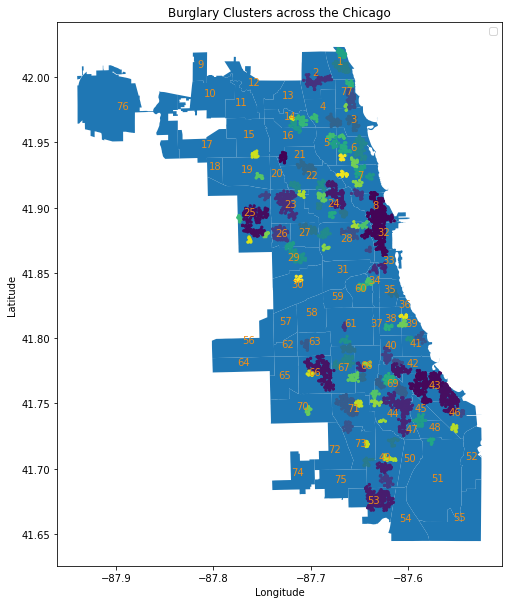

In [110]:
DBSCAN_result_withoutNoise = DBSCAN_result.drop(
    DBSCAN_result[DBSCAN_result.DBSCAN_opt_labels == -1].index
)  # remove points that do not belong to a cluster

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Burglary Clusters across the Chicago")

chicago_community.plot(ax=ax, legend=True, column="community", categorical=True)
chicago_community.apply(
    lambda x: ax.annotate(
        text=x["community number"], xy=x.geometry.centroid.coords[0], ha="center", color='#ee8d18'
    ),
    axis=1,
)
ax.scatter(
    DBSCAN_result_withoutNoise["longitude"],
    DBSCAN_result_withoutNoise["latitude"],
    c=DBSCAN_result_withoutNoise["DBSCAN_opt_labels"],
    s=5,
)
ax.legend()

In [107]:
chicago_community

,area,community number,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
9,0.0,1,0.0,0.0,community,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998..."
19,0.0,2,0.0,0.0,community,0.0,9.842909e+07,43020.689458,"POLYGON ((-87.68465 42.01948, -87.68464 42.019..."
30,0.0,3,0.0,0.0,community,0.0,6.509564e+07,46972.794555,"POLYGON ((-87.64102 41.95480, -87.64400 41.954..."
5,0.0,4,0.0,0.0,community,0.0,7.135233e+07,36624.603085,"POLYGON ((-87.67441 41.97610, -87.67440 41.976..."
47,0.0,5,0.0,0.0,community,0.0,5.705417e+07,31391.669754,"POLYGON ((-87.67336 41.93234, -87.67342 41.932..."
...,...,...,...,...,...,...,...,...,...
71,0.0,73,0.0,0.0,community,0.0,7.963575e+07,42222.598163,"POLYGON ((-87.63373 41.72885, -87.63369 41.726..."
72,0.0,74,0.0,0.0,community,0.0,7.558429e+07,48665.130539,"POLYGON ((-87.69646 41.70714, -87.69644 41.706..."
73,0.0,75,0.0,0.0,community,0.0,9.187734e+07,46396.419362,"POLYGON ((-87.64215 41.68508, -87.64249 41.685..."
74,0.0,76,0.0,0.0,community,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."


# Bibliography

FBI UCR. 2019. Burglary. [online] Available at: <https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/topic-pages/burglary> [Accessed 17 March 2022].

Craglia, M., Haining, R. and Wiles, P., 2000. A Comparative Evaluation of Approaches to Urban Crime Pattern Analysis. Urban Studies, 37(4), pp.711-729.

Andresen, M., 2005. Crime Measures and the Spatial Analysis of Criminal Activity. The British Journal of Criminology, 46(2), pp.258-285.

Mungekar, D., Joshi, H., Kankekar, A., Nair, P. and Das, P., 2021. Crime Analysis using DBSCAN Algorithm. 2021 Third International Conference on Inventive Research in Computing Applications (ICIRCA),.

Sivaranjani, S., Sivakumari, S. and Aasha, M., 2016. Crime prediction and forecasting in Tamilnadu using clustering approaches. 2016 International Conference on Emerging Technological Trends (ICETT),.

Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). A density-based algorithm for discovering clusters in large spatial databases with noise. 226–231.

Rahmah, N. and Sitanggang, I., 2016. Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra. IOP Conference Series: Earth and Environmental Science, 31, p.012012.